In [1]:
# Install required packages (if needed)
# !pip3 install pandas numpy matplotlib seaborn scikit-learn tqdm requests -q

# Ollama API setup and imports
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np
from datetime import datetime

print("✓ Libraries imported successfully")
print("✓ Ollama will be used for LLM inference (local)")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# Ollama API configuration
OLLAMA_API_URL = "http://localhost:11434/api/generate"

✓ Libraries imported successfully
✓ Ollama will be used for LLM inference (local)


## 1. Load Dataset

In [2]:
# Load the 100% agreement dataset (highest quality)
data_path = "../../DatasetAnalysis_FinancialPhraseBank/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt"

sentences = []
sentiments = []

with open(data_path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        line = line.strip()
        if "@" in line:
            parts = line.rsplit("@", 1)
            if len(parts) == 2:
                sentences.append(parts[0])
                sentiments.append(parts[1])

df = pd.DataFrame({"sentence": sentences, "true_sentiment": sentiments})

print(f"Dataset loaded: {len(df)} sentences")
print(f"\nSentiment distribution:")
print(df["true_sentiment"].value_counts())

# Display sample
print("\n" + "=" * 80)
print("Sample sentences:")
print("=" * 80)
display(df.sample(5, random_state=42))

Dataset loaded: 2264 sentences

Sentiment distribution:
true_sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

Sample sentences:


,sentence,true_sentiment
1755,The contract value amounts to EUR 2.4 million .,neutral
1281,Kemira shares closed at ( x20ac ) 16.66 ( $ 2...,neutral
350,The company slipped to an operating loss of EU...,negative
420,According to Atria 's President and CEO Matti ...,positive
56,"In 2009 , Fiskars ' cash flow from operating a...",positive


## 2. Chain-of-Thought Prompt Design

**Prompt Strategy**: Stepwise reasoning with explicit JSON output format.

In [3]:
def create_cot_prompt(sentence):
    """
    Creates a Chain-of-Thought prompt for sentiment classification.
    Guides the model through stepwise reasoning with emphasis on negative detection.
    """
    prompt = f"""You are a financial sentiment analysis expert. Use step-by-step reasoning to classify this financial statement.

Task: Classify the sentiment of the following financial statement as "positive", "negative", or "neutral" from an investor's perspective, using stepwise reasoning.

Guidelines:
- Positive: Financial improvements, growth, profits, revenue increases, cost reductions, successful expansions
- Negative: Financial declines, losses, revenue drops, cost increases, failed ventures, layoffs, legal issues
- Neutral: Factual statements with no clear financial impact, routine announcements, or balanced mixed signals

Financial Statement:
"{sentence}"

Think step by step. Return ONLY strictly JSON in this exact format:
{{
    "sentiment": "positive/negative/neutral",
    "confidence": 0.0-1.0,
    "rationale": "Step-by-step reasoning in one or two sentences"
}}
"""
    return prompt

## 3. Model Inference Functions

In [4]:
def call_ollama(prompt, model_name, temperature=0.0):
    """Call Ollama API for LLM inference"""
    max_retries = 3
    last_error = None
    
    for attempt in range(max_retries):
        try:
            response = requests.post(
                OLLAMA_API_URL,
                json={
                    "model": model_name,
                    "prompt": prompt,
                    "stream": False,
                    "temperature": temperature,
                },
                timeout=60,
            )
            
            if response.status_code == 200:
                result = response.json()
                return result.get("response", "")
            else:
                last_error = f"HTTP {response.status_code}"
                
        except Exception as e:
            last_error = str(e)
            print(f"Attempt {attempt + 1}/{max_retries} failed: {last_error}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
                continue
            return None
    
    return None


def parse_response(response_text):
    """Parse JSON response from model"""
    try:
        # Try to extract JSON from response
        if "```json" in response_text:
            json_str = response_text.split("```json")[1].split("```")[0].strip()
        elif "```" in response_text:
            json_str = response_text.split("```")[1].split("```")[0].strip()
        else:
            json_str = response_text.strip()
        
        result = json.loads(json_str)
        return result
        
    except Exception as e:
        # Fallback: try to extract sentiment with regex
        response_lower = response_text.lower() if response_text else ""
        if "positive" in response_lower and "negative" not in response_lower:
            return {
                "sentiment": "positive",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "negative" in response_lower:
            return {
                "sentiment": "negative",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        elif "neutral" in response_lower:
            return {
                "sentiment": "neutral",
                "confidence": 0.5,
                "rationale": "Parsed from text",
            }
        return None


print("✓ Model inference functions defined")

✓ Model inference functions defined


## 4. Run Experiments

### E7: Llama3.1:8b (Chain-of-Thought)

In [5]:
# Run on full dataset for comprehensive evaluation
test_df = df.head(200).copy()

# E7: Llama3.1:8b (Chain-of-Thought)
print("Running E7: Llama3.1:8b (Chain-of-Thought)...")
e7_results = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E7 Progress"):
    prompt = create_cot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="llama3.1:8b")
    if response:
        parsed = parse_response(response)
        if parsed:
            e7_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e7_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )
    time.sleep(0.1)

e7_df = pd.DataFrame(e7_results)
print(f"\n✓ E7 completed: {len(e7_df)} predictions")
display(e7_df.head())


Running E7: Llama3.1:8b (Chain-of-Thought)...


E7 Progress: 100%|██████████| 200/200 [31:39<00:00,  9.50s/it]


✓ E7 completed: 200 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.80,The statement provides factual information abo...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.90,"Componenta's net sales doubled, and it moved f..."
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,The statement reports a significant increase i...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.90,The financial statement mentions an increase i...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.90,The statement mentions an increase in operatin...


### E8: Qwen3:8b (Chain-of-Thought)

In [6]:

# E8: Qwen3:8b (Chain-of-Thought)
print("\nRunning E8: Qwen3:8b (Chain-of-Thought)...")
e8_results = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E8 Progress"):
    prompt = create_cot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="qwen3:8b")
    if response:
        parsed = parse_response(response)
        if parsed:
            e8_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e8_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )
    time.sleep(0.1)

e8_df = pd.DataFrame(e8_results)
print(f"\n✓ E8 completed: {len(e8_df)} predictions")
display(e8_df.head())



Running E8: Qwen3:8b (Chain-of-Thought)...


E8 Progress: 100%|██████████| 200/200 [1:11:03<00:00, 21.32s/it]


✓ E8 completed: 200 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.70,The statement clarifies the company's producti...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.90,The statement highlights doubled net sales (po...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.95,The statement reports significant increases in...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.95,The statement highlights a significant increas...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.95,The statement shows a clear increase in operat...


### E9: DeepSeek-R1:8b (Chain-of-Thought)

In [7]:

# E9: DeepSeek-R1:8b (Chain-of-Thought)
print("\nRunning E9: DeepSeek-R1:8b (Chain-of-Thought)...")
e9_results = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="E9 Progress"):
    prompt = create_cot_prompt(row["sentence"])
    response = call_ollama(prompt, model_name="deepseek-r1:8b")
    if response:
        parsed = parse_response(response)
        if parsed:
            e9_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": parsed.get("sentiment", "unknown"),
                    "confidence": parsed.get("confidence", 0),
                    "rationale": parsed.get("rationale", ""),
                }
            )
        else:
            e9_results.append(
                {
                    "sentence": row["sentence"],
                    "true_sentiment": row["true_sentiment"],
                    "predicted_sentiment": "error",
                    "confidence": 0,
                    "rationale": "Parse error",
                }
            )
    time.sleep(0.1)

e9_df = pd.DataFrame(e9_results)
print(f"\n✓ E9 completed: {len(e9_df)} predictions")
display(e9_df.head())


Running E9: DeepSeek-R1:8b (Chain-of-Thought)...


E9 Progress: 100%|██████████| 200/200 [1:07:22<00:00, 20.21s/it]


✓ E9 completed: 200 predictions


,sentence,true_sentiment,predicted_sentiment,confidence,rationale
0,"According to Gran , the company has no plans t...",neutral,neutral,0.75,The statement indicates growth in Russia but e...
1,"For the last quarter of 2010 , Componenta 's n...",positive,positive,0.85,The statement shows a doubling of net sales (p...
2,"In the third quarter of 2010 , net sales incre...",positive,positive,0.90,The statement reports significant increases in...
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,positive,0.80,The statement reports a significant increase i...
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,positive,0.90,The statement reports an increase in operating...


## 5. Calculate Metrics

In [8]:
# Calculate metrics for all experiments
def calculate_metrics(df, exp_name):
    """Calculate all evaluation metrics"""
    if df.empty or "predicted_sentiment" not in df.columns:
        print(f"⚠️ Warning: {exp_name} has no valid predictions!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": 0,
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "Macro-Recall": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    valid_df = df[
        df["predicted_sentiment"].isin(["positive", "negative", "neutral"])
    ].copy()
    if valid_df.empty:
        print(f"⚠️ Warning: {exp_name} has no valid predictions after filtering!")
        return (
            {
                "Experiment": exp_name,
                "Total Samples": len(df),
                "Valid Predictions": 0,
                "Accuracy": 0,
                "Macro-F1": 0,
                "Weighted-F1": 0,
                "Macro-Precision": 0,
                "MCC": 0,
                "Positive_Precision": 0,
                "Positive_Recall": 0,
                "Positive_F1": 0,
                "Negative_Precision": 0,
                "Negative_Recall": 0,
                "Negative_F1": 0,
                "Neutral_Precision": 0,
                "Neutral_Recall": 0,
                "Neutral_F1": 0,
            },
            np.zeros((3, 3)),
            pd.DataFrame(),
        )

    y_true = valid_df["true_sentiment"]
    y_pred = valid_df["predicted_sentiment"]

    metrics = {
        "Experiment": exp_name,
        "Total Samples": len(df),
        "Valid Predictions": len(valid_df),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro-F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted-F1": f1_score(y_true, y_pred, average="weighted"),
        "Macro-Precision": precision_score(y_true, y_pred, average="macro"),
        "Macro-Recall": recall_score(y_true, y_pred, average="macro"),
        "MCC": matthews_corrcoef(y_true, y_pred),
    }

    labels = ["positive", "negative", "neutral"]
    precision_per_class = precision_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    recall_per_class = recall_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )
    f1_per_class = f1_score(
        y_true, y_pred, labels=labels, average=None, zero_division=0
    )

    for i, label in enumerate(labels):
        metrics[f"{label.capitalize()}_Precision"] = precision_per_class[i]
        metrics[f"{label.capitalize()}_Recall"] = recall_per_class[i]
        metrics[f"{label.capitalize()}_F1"] = f1_per_class[i]

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return metrics, cm, valid_df


# Calculate metrics for all experiments
e7_metrics, e7_cm, e7_valid = calculate_metrics(e7_df, "E7: Llama3.1:8b (CoT)")
e8_metrics, e8_cm, e8_valid = calculate_metrics(e8_df, "E8: Qwen3:8b (CoT)")
e9_metrics, e9_cm, e9_valid = calculate_metrics(e9_df, "E9: DeepSeek-R1:8b (CoT)")

metrics_df = pd.DataFrame([e7_metrics, e8_metrics, e9_metrics])
print("\n" + "=" * 80)
print("CHAIN-OF-THOUGHT PERFORMANCE COMPARISON")
print("=" * 80)
display(
    metrics_df[
        ["Experiment", "Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
    ].round(4)
)


CHAIN-OF-THOUGHT PERFORMANCE COMPARISON


,Experiment,Accuracy,Macro-F1,Macro-Precision,Macro-Recall
0,E7: Llama3.1:8b (CoT),0.99,0.8724,0.9949,0.8000
1,E8: Qwen3:8b (CoT),1.00,1.0000,1.0000,1.0000
2,E9: DeepSeek-R1:8b (CoT),0.99,0.9141,0.8571,0.9949


## 6. Visualize Results

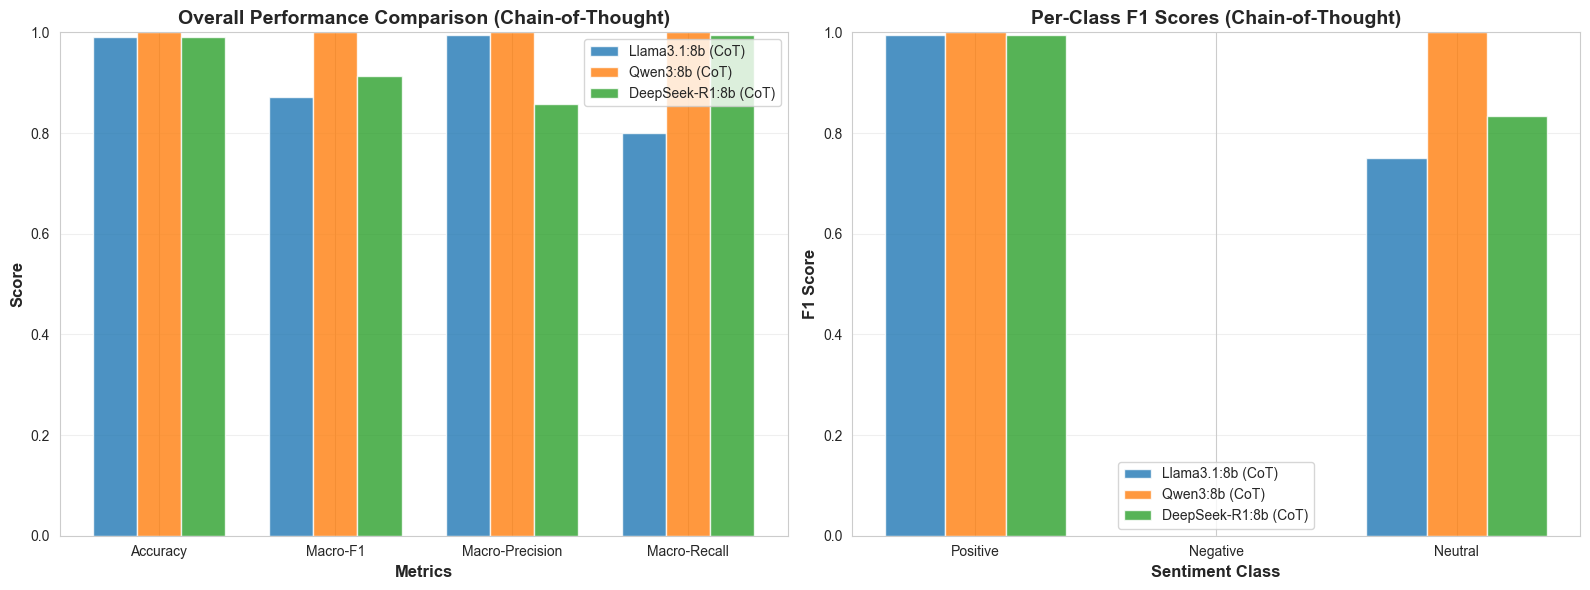

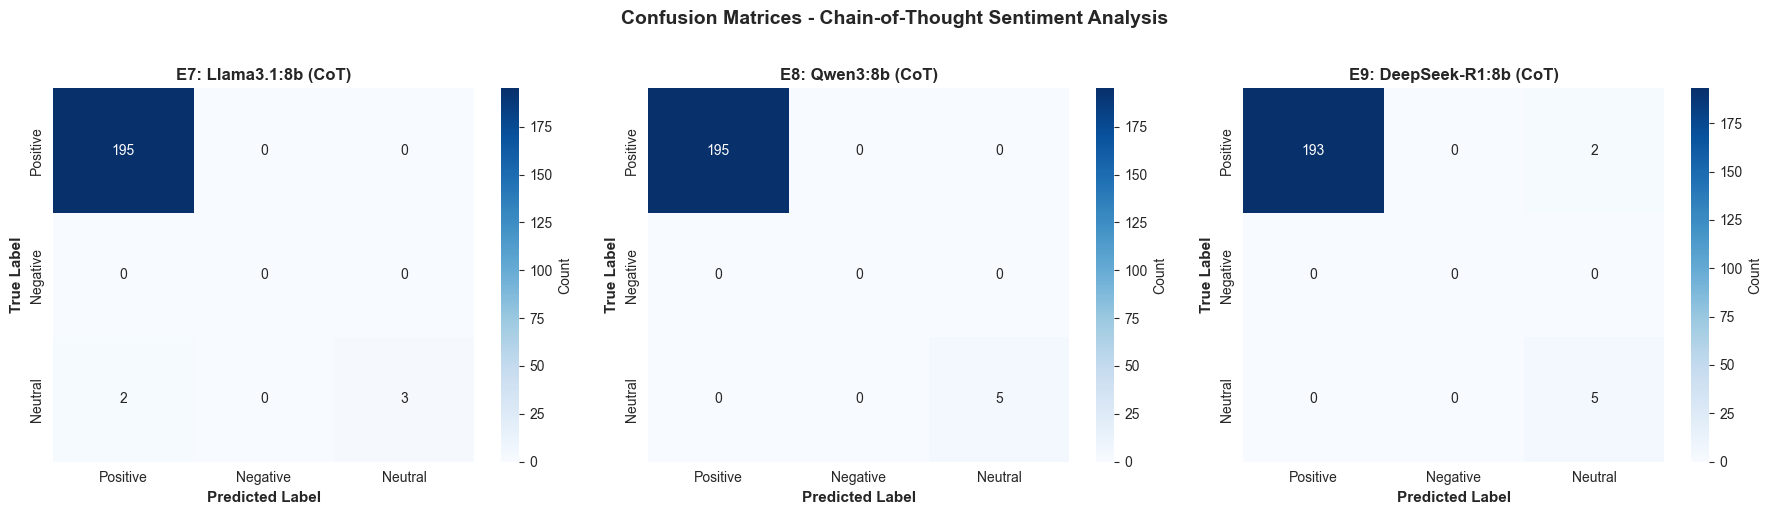

In [9]:
# Performance comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall metrics
metrics_to_plot = ["Accuracy", "Macro-F1", "Macro-Precision", "Macro-Recall"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, (metrics, label) in enumerate(
    [
        (e7_metrics, "Llama3.1:8b (CoT)"),
        (e8_metrics, "Qwen3:8b (CoT)"),
        (e9_metrics, "DeepSeek-R1:8b (CoT)"),
    ]
):
    values = [metrics[m] for m in metrics_to_plot]
    axes[0].bar(x + i * width, values, width, label=label, alpha=0.8)

axes[0].set_xlabel("Metrics", fontsize=12, weight="bold")
axes[0].set_ylabel("Score", fontsize=12, weight="bold")
axes[0].set_title(
    "Overall Performance Comparison (Chain-of-Thought)", fontsize=14, weight="bold"
)
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics_to_plot)
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].grid(axis="y", alpha=0.3)

# Per-class F1 scores
classes = ["Positive", "Negative", "Neutral"]
x2 = np.arange(len(classes))

for i, (metrics, label) in enumerate(
    [
        (e7_metrics, "Llama3.1:8b (CoT)"),
        (e8_metrics, "Qwen3:8b (CoT)"),
        (e9_metrics, "DeepSeek-R1:8b (CoT)"),
    ]
):
    values = [metrics[f"{c}_F1"] for c in classes]
    axes[1].bar(x2 + i * width, values, width, label=label, alpha=0.8)

axes[1].set_xlabel("Sentiment Class", fontsize=12, weight="bold")
axes[1].set_ylabel("F1 Score", fontsize=12, weight="bold")
axes[1].set_title("Per-Class F1 Scores (Chain-of-Thought)", fontsize=14, weight="bold")
axes[1].set_xticks(x2 + width)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("cot_performance_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
labels = ["Positive", "Negative", "Neutral"]

for idx, (cm, title) in enumerate(
    [
        (e7_cm, "E7: Llama3.1:8b (CoT)"),
        (e8_cm, "E8: Qwen3:8b (CoT)"),
        (e9_cm, "E9: DeepSeek-R1:8b (CoT)"),
    ]
):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        ax=axes[idx],
        cbar_kws={"label": "Count"},
    )
    axes[idx].set_title(title, fontsize=12, weight="bold")
    axes[idx].set_ylabel("True Label", fontsize=11, weight="bold")
    axes[idx].set_xlabel("Predicted Label", fontsize=11, weight="bold")

plt.suptitle(
    "Confusion Matrices - Chain-of-Thought Sentiment Analysis",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("cot_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

## 7. Save Results

In [10]:
# Save detailed results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

e7_df.to_csv(f"e7_llama3.1_8b_cot_{timestamp}.csv", index=False)
e8_df.to_csv(f"e8_qwen3_8b_cot_{timestamp}.csv", index=False)
e9_df.to_csv(f"e9_deepseek_r1_8b_cot_{timestamp}.csv", index=False)

# Save metrics summary
metrics_df.to_csv(f"cot_metrics_summary_{timestamp}.csv", index=False)

print(f"\n✓ Chain-of-Thought results saved with timestamp: {timestamp}")
print("\nFiles created:")
print(f"  - e7_llama3.1_8b_cot_{timestamp}.csv")
print(f"  - e8_qwen3_8b_cot_{timestamp}.csv")
print(f"  - e9_deepseek_r1_8b_cot_{timestamp}.csv")
print(f"  - cot_metrics_summary_{timestamp}.csv")
print(f"  - cot_performance_comparison.png")
print(f"  - cot_confusion_matrices.png")


✓ Chain-of-Thought results saved with timestamp: 20260211_115925

Files created:
  - e7_llama3.1_8b_cot_20260211_115925.csv
  - e8_qwen3_8b_cot_20260211_115925.csv
  - e9_deepseek_r1_8b_cot_20260211_115925.csv
  - cot_metrics_summary_20260211_115925.csv
  - cot_performance_comparison.png
  - cot_confusion_matrices.png


## 8. Error Analysis

In [11]:
# Error Analysis: Most Common Misclassifications
print("=" * 80)
print("ERROR ANALYSIS: CHAIN-OF-THOUGHT MISCLASSIFICATION PATTERNS")
print("=" * 80)

for df_result, exp_name in [
    (e7_valid, "E7: Llama3.1:8b"),
    (e8_valid, "E8: Qwen3:8b"),
    (e9_valid, "E9: DeepSeek-R1:8b"),
]:
    print(f"\n{exp_name}")
    print("-" * 80)

    # Identify errors
    errors = df_result[df_result["true_sentiment"] != df_result["predicted_sentiment"]]

    # Count error types
    error_types = (
        errors.groupby(["true_sentiment", "predicted_sentiment"])
        .size()
        .reset_index(name="count")
    )
    error_types = error_types.sort_values("count", ascending=False)

    print(
        f"\nTotal Errors: {len(errors)} / {len(df_result)} ({len(errors) / len(df_result) * 100:.2f}%)"
    )
    print("\nMost Common Error Types:")
    display(error_types.head(5))

    # Show examples of worst errors (high confidence, wrong prediction)
    if len(errors) > 0:
        worst_errors = errors.nlargest(3, "confidence")
        print(f"\nTop 3 High-Confidence Errors:")
        for idx, row in worst_errors.iterrows():
            print(
                f"\n  True: {row['true_sentiment']} | Predicted: {row['predicted_sentiment']} | Conf: {row['confidence']:.2f}"
            )
            print(f"  Sentence: {row['sentence'][:120]}...")
            print(f"  Rationale: {row['rationale']}")

# Class-wise Performance Comparison
print("\n" + "=" * 80)
print("CLASS-WISE PERFORMANCE BREAKDOWN")
print("=" * 80)

class_comparison = []
for metrics, model_name in [
    (e7_metrics, "Llama3.1:8b"),
    (e8_metrics, "Qwen3:8b"),
    (e9_metrics, "DeepSeek-R1:8b"),
]:
    for sentiment in ["Positive", "Negative", "Neutral"]:
        class_comparison.append(
            {
                "Model": model_name,
                "Class": sentiment,
                "Precision": metrics[f"{sentiment}_Precision"],
                "Recall": metrics[f"{sentiment}_Recall"],
                "F1-Score": metrics[f"{sentiment}_F1"],
            }
        )

class_df = pd.DataFrame(class_comparison)

# Pivot for better visualization
for metric in ["Precision", "Recall", "F1-Score"]:
    print(f"\n{metric} by Class:")
    pivot = class_df.pivot(index="Class", columns="Model", values=metric)
    display(pivot.round(4))

print("\n" + "=" * 80)
print("COMPREHENSIVE METRICS TABLE")
print("=" * 80)
display(metrics_df.round(4))

ERROR ANALYSIS: CHAIN-OF-THOUGHT MISCLASSIFICATION PATTERNS

E7: Llama3.1:8b
--------------------------------------------------------------------------------

Total Errors: 2 / 200 (1.00%)

Most Common Error Types:


,true_sentiment,predicted_sentiment,count
0,neutral,positive,2



Top 3 High-Confidence Errors:

  True: neutral | Predicted: positive | Conf: 0.90
  Sentence: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL...
  Rationale: The statement mentions a subscription of shares, implying an increase in share capital, which is generally considered a positive financial development.

  True: neutral | Predicted: positive | Conf: 0.80
  Sentence: Tiimari operates 194 stores in six countries -- including its core Finnish market -- and generated a turnover of 76.5 ml...
  Rationale: The statement mentions a specific turnover figure, implying financial performance, and the fact that it is mentioned as a generated revenue suggests an increase rather than a decrease.

E8: Qwen3:8b
--------------------------------------------------------------------------------

Total Errors: 0 / 200 (0.00%)

Most Common Error Types:


,true_sentiment,predicted_sentiment,count



E9: DeepSeek-R1:8b
--------------------------------------------------------------------------------

Total Errors: 2 / 200 (1.00%)

Most Common Error Types:


,true_sentiment,predicted_sentiment,count
0,positive,neutral,2



Top 3 High-Confidence Errors:

  True: positive | Predicted: neutral | Conf: 0.75
  Sentence: In January , traffic , measured in revenue passenger kilometres RPK , went up by 3.2 % and capacity , measured in availa...
  Rationale: The statement reports growth in both revenue passenger kilometers (RPK) and available seat kilometers (ASK), but does not provide context on the financial impact (e.g., profitability or costs). While the growth is positive, the lack of information on overall financial health or comparison to costs makes the sentiment neutral.

  True: positive | Predicted: neutral | Conf: 0.70
  Sentence: Finland-based Elcoteq SE , a privately held provider of electronics manufacturing services to communications companies ,...
  Rationale: The statement reports a factual event (a long-term supply deal) without specifying financial terms, outcomes, or clear financial improvement, keeping the sentiment neutral despite the potential positive implications.

CLASS-WISE PERFORMANC

Model,DeepSeek-R1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.0000,0.0
Neutral,0.7143,1.0000,1.0
Positive,1.0000,0.9898,1.0



Recall by Class:


Model,DeepSeek-R1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.0,0.0
Neutral,1.0000,0.6,1.0
Positive,0.9897,1.0,1.0



F1-Score by Class:


Model,DeepSeek-R1:8b,Llama3.1:8b,Qwen3:8b
Class,,,
Negative,0.0000,0.0000,0.0
Neutral,0.8333,0.7500,1.0
Positive,0.9948,0.9949,1.0



COMPREHENSIVE METRICS TABLE


,Experiment,Total Samples,Valid Predictions,Accuracy,Macro-F1,Weighted-F1,Macro-Precision,Macro-Recall,MCC,Positive_Precision,Positive_Recall,Positive_F1,Negative_Precision,Negative_Recall,Negative_F1,Neutral_Precision,Neutral_Recall,Neutral_F1
0,E7: Llama3.1:8b (CoT),200,200,0.99,0.8724,0.9888,0.9949,0.8000,0.7707,0.9898,1.0000,0.9949,0.0,0.0,0.0,1.0000,0.6,0.7500
1,E8: Qwen3:8b (CoT),200,200,1.00,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0,0.0,0.0,1.0000,1.0,1.0000
2,E9: DeepSeek-R1:8b (CoT),200,200,0.99,0.9141,0.9908,0.8571,0.9949,0.8408,1.0000,0.9897,0.9948,0.0,0.0,0.0,0.7143,1.0,0.8333


## 9. Confidence Analysis

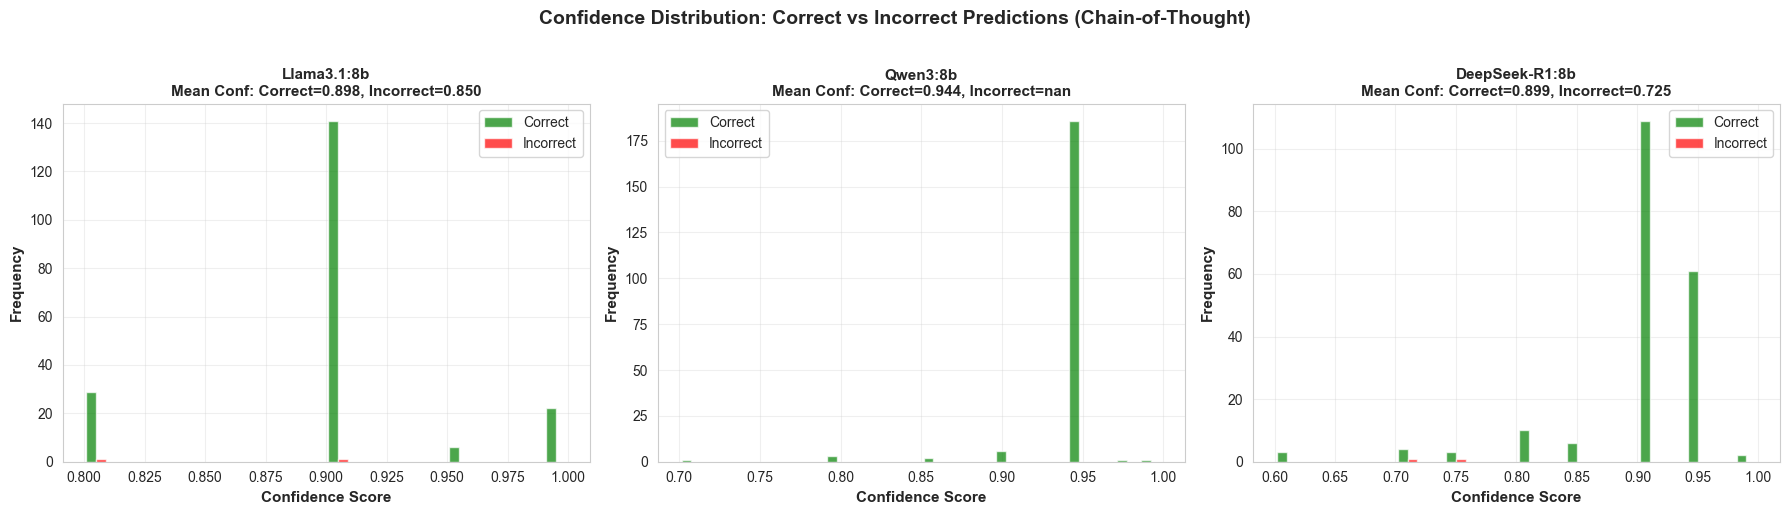


CONFIDENCE CALIBRATION ANALYSIS

E7: Llama3.1:8b:
  Average Confidence (Correct): 0.8980
  Average Confidence (Incorrect): 0.8500
  Calibration Gap: 0.0480
  Total Correct: 198 / 200

  Confidence by Predicted Class:
    Positive: 0.8970 (n=197)
    Neutral: 0.9333 (n=3)

E8: Qwen3:8b:
  Average Confidence (Correct): 0.9444
  Average Confidence (Incorrect): nan
  Calibration Gap: nan
  Total Correct: 200 / 200

  Confidence by Predicted Class:
    Positive: 0.9461 (n=195)
    Neutral: 0.8800 (n=5)

E9: DeepSeek-R1:8b:
  Average Confidence (Correct): 0.8990
  Average Confidence (Incorrect): 0.7250
  Calibration Gap: 0.1740
  Total Correct: 198 / 200

  Confidence by Predicted Class:
    Positive: 0.9013 (n=193)
    Neutral: 0.7857 (n=7)


In [12]:
# Confidence Analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (df_result, title) in enumerate(
    [(e7_valid, "Llama3.1:8b"), (e8_valid, "Qwen3:8b"), (e9_valid, "DeepSeek-R1:8b")]
):
    df_result["correct"] = (
        df_result["true_sentiment"] == df_result["predicted_sentiment"]
    )

    correct_conf = df_result[df_result["correct"]]["confidence"]
    incorrect_conf = df_result[~df_result["correct"]]["confidence"]

    axes[idx].hist(
        [correct_conf, incorrect_conf],
        bins=20,
        label=["Correct", "Incorrect"],
        alpha=0.7,
        color=["green", "red"],
    )
    axes[idx].set_xlabel("Confidence Score", fontsize=11, weight="bold")
    axes[idx].set_ylabel("Frequency", fontsize=11, weight="bold")
    axes[idx].set_title(
        f"{title}\nMean Conf: Correct={correct_conf.mean():.3f}, Incorrect={incorrect_conf.mean():.3f}",
        fontsize=11,
        weight="bold",
    )
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.suptitle(
    "Confidence Distribution: Correct vs Incorrect Predictions (Chain-of-Thought)",
    fontsize=14,
    weight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("cot_confidence_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n" + "=" * 80)
print("CONFIDENCE CALIBRATION ANALYSIS")
print("=" * 80)
for df_result, exp_name in [
    (e7_valid, "E7: Llama3.1:8b"),
    (e8_valid, "E8: Qwen3:8b"),
    (e9_valid, "E9: DeepSeek-R1:8b"),
]:
    df_result["correct"] = (
        df_result["true_sentiment"] == df_result["predicted_sentiment"]
    )

    avg_conf_correct = df_result[df_result["correct"]]["confidence"].mean()
    avg_conf_incorrect = df_result[~df_result["correct"]]["confidence"].mean()
    calibration_gap = avg_conf_correct - avg_conf_incorrect

    print(f"\n{exp_name}:")
    print(f"  Average Confidence (Correct): {avg_conf_correct:.4f}")
    print(f"  Average Confidence (Incorrect): {avg_conf_incorrect:.4f}")
    print(f"  Calibration Gap: {calibration_gap:.4f}")
    print(f"  Total Correct: {df_result['correct'].sum()} / {len(df_result)}")

    # Confidence by sentiment class
    print(f"\n  Confidence by Predicted Class:")
    for sentiment in ["positive", "negative", "neutral"]:
        class_df = df_result[df_result["predicted_sentiment"] == sentiment]
        if len(class_df) > 0:
            print(
                f"    {sentiment.capitalize()}: {class_df['confidence'].mean():.4f} (n={len(class_df)})"
            )

## 10. Classification Reports

In [13]:
# Detailed Classification Reports
print("\n" + "=" * 80)
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 80)

for df_result, exp_name in [
    (e7_valid, "E7: Llama3.1:8b"),
    (e8_valid, "E8: Qwen3:8b"),
    (e9_valid, "E9: DeepSeek-R1:8b"),
]:
    print("\n" + "=" * 80)
    print(f"{exp_name}")
    print("=" * 80)
    print(
        classification_report(
            df_result["true_sentiment"],
            df_result["predicted_sentiment"],
            labels=["positive", "negative", "neutral"],
            target_names=["Positive", "Negative", "Neutral"],
        )
    )

# Class-wise Metrics Summary Table
print("\n" + "=" * 80)
print("CLASS-WISE METRICS SUMMARY")
print("=" * 80)

summary_data = []
for metrics, model in [
    (e7_metrics, "Llama3.1:8b"),
    (e8_metrics, "Qwen3:8b"),
    (e9_metrics, "DeepSeek-R1:8b"),
]:
    summary_data.append(
        {
            "Model": model,
            "Pos_P": metrics["Positive_Precision"],
            "Pos_R": metrics["Positive_Recall"],
            "Pos_F1": metrics["Positive_F1"],
            "Neg_P": metrics["Negative_Precision"],
            "Neg_R": metrics["Negative_Recall"],
            "Neg_F1": metrics["Negative_F1"],
            "Neu_P": metrics["Neutral_Precision"],
            "Neu_R": metrics["Neutral_Recall"],
            "Neu_F1": metrics["Neutral_F1"],
        }
    )

summary_df = pd.DataFrame(summary_data)
print("\nPer-Class Metrics (P=Precision, R=Recall, F1=F1-Score):")
display(summary_df.round(4))


DETAILED CLASSIFICATION REPORTS

E7: Llama3.1:8b
              precision    recall  f1-score   support

    Positive       0.99      1.00      0.99       195
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      0.60      0.75         5

    accuracy                           0.99       200
   macro avg       0.66      0.53      0.58       200
weighted avg       0.99      0.99      0.99       200


E8: Qwen3:8b
              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00       195
    Negative       0.00      0.00      0.00         0
     Neutral       1.00      1.00      1.00         5

    accuracy                           1.00       200
   macro avg       0.67      0.67      0.67       200
weighted avg       1.00      1.00      1.00       200


E9: DeepSeek-R1:8b
              precision    recall  f1-score   support

    Positive       1.00      0.99      0.99       195
    Negative       0.00      0.00      0.00  

/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sidharthrai/Documents/LJMU - MS AI ML/Prompt_Engineering_for_Financial_Texts/pmp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and bei

,Model,Pos_P,Pos_R,Pos_F1,Neg_P,Neg_R,Neg_F1,Neu_P,Neu_R,Neu_F1
0,Llama3.1:8b,0.9898,1.0000,0.9949,0.0,0.0,0.0,1.0000,0.6,0.7500
1,Qwen3:8b,1.0000,1.0000,1.0000,0.0,0.0,0.0,1.0000,1.0,1.0000
2,DeepSeek-R1:8b,1.0000,0.9897,0.9948,0.0,0.0,0.0,0.7143,1.0,0.8333


## 11. CoT vs Few-Shot vs Zero-Shot Comparison

In [14]:
# Compare with Few-Shot and Zero-Shot results (if available)
import glob
import os

print("=" * 80)
print("CHAIN-OF-THOUGHT vs FEW-SHOT vs ZERO-SHOT COMPARISON")
print("=" * 80)

# Try to load Few-Shot and Zero-Shot results
few_shot_files = glob.glob("../Few_Shot/few_shot_metrics_summary_*.csv")
zero_shot_files = glob.glob("../Zero_Shot/zero_shot_metrics_summary_*.csv")

comparison_data = [metrics_df.copy()]
comparison_data[0]["Approach"] = "Chain-of-Thought"

if few_shot_files:
    latest_few_shot = max(few_shot_files, key=os.path.getctime)
    print(f"\n✓ Loading Few-Shot results from: {os.path.basename(latest_few_shot)}")
    try:
        few_shot_df = pd.read_csv(latest_few_shot)
        few_shot_df["Approach"] = "Few-Shot"
        comparison_data.append(few_shot_df)
    except Exception as e:
        print(f"  ⚠️ Could not load few-shot results: {str(e)}")
else:
    print("\n⚠️ No Few-Shot results found")

if zero_shot_files:
    latest_zero_shot = max(zero_shot_files, key=os.path.getctime)
    print(f"✓ Loading Zero-Shot results from: {os.path.basename(latest_zero_shot)}")
    try:
        zero_shot_df = pd.read_csv(latest_zero_shot)
        zero_shot_df["Approach"] = "Zero-Shot"
        comparison_data.append(zero_shot_df)
    except Exception as e:
        print(f"  ⚠️ Could not load zero-shot results: {str(e)}")
else:
    print("⚠️ No Zero-Shot results found")

if len(comparison_data) > 1:
    combined = pd.concat(comparison_data, ignore_index=True)

    # Select key metrics for comparison
    comparison_cols = [
        "Experiment",
        "Approach",
        "Accuracy",
        "Macro-F1",
        "MCC",
        "Negative_F1",
        "Positive_F1",
        "Neutral_F1",
    ]

    available_cols = [col for col in comparison_cols if col in combined.columns]

    print("\n" + "=" * 80)
    print("KEY METRICS COMPARISON")
    print("=" * 80)
    display(combined[available_cols].round(4))

    # Calculate improvements
    if len(comparison_data) == 3:  # All three approaches available
        print("\n" + "=" * 80)
        print("PERFORMANCE PROGRESSION")
        print("=" * 80)

        for i in range(min(3, len(metrics_df))):
            model_name = ["Llama3.1:8b", "Qwen3:8b", "DeepSeek-R1:8b"][i]
            print(f"\n{model_name}:")

            if i < len(zero_shot_df):
                zs_macro = zero_shot_df.iloc[i]["Macro-F1"]
                print(f"  Zero-Shot Macro-F1: {zs_macro:.4f}")

            if i < len(few_shot_df):
                fs_macro = few_shot_df.iloc[i]["Macro-F1"]
                zs_to_fs = (
                    ((fs_macro - zs_macro) / zs_macro * 100) if zs_macro > 0 else 0
                )
                print(
                    f"  Few-Shot Macro-F1:  {fs_macro:.4f} ({zs_to_fs:+.2f}% vs Zero-Shot)"
                )

            cot_macro = metrics_df.iloc[i]["Macro-F1"]
            fs_to_cot = ((cot_macro - fs_macro) / fs_macro * 100) if fs_macro > 0 else 0
            total_improvement = (
                ((cot_macro - zs_macro) / zs_macro * 100) if zs_macro > 0 else 0
            )
            print(
                f"  CoT Macro-F1:       {cot_macro:.4f} ({fs_to_cot:+.2f}% vs Few-Shot, {total_improvement:+.2f}% vs Zero-Shot)"
            )

            # Negative F1 comparison
            print(f"\n  Negative F1 Progression:")
            if i < len(zero_shot_df):
                zs_neg = zero_shot_df.iloc[i]["Negative_F1"]
                print(f"    Zero-Shot: {zs_neg:.4f}")
            if i < len(few_shot_df):
                fs_neg = few_shot_df.iloc[i]["Negative_F1"]
                print(f"    Few-Shot:  {fs_neg:.4f}")
            cot_neg = metrics_df.iloc[i]["Negative_F1"]
            print(f"    CoT:       {cot_neg:.4f}")
else:
    print("\n⚠️ Run Few-Shot and Zero-Shot experiments for complete comparison")

CHAIN-OF-THOUGHT vs FEW-SHOT vs ZERO-SHOT COMPARISON

✓ Loading Few-Shot results from: few_shot_metrics_summary_20260211_085346.csv
✓ Loading Zero-Shot results from: zero_shot_metrics_summary_20260211_053519.csv

KEY METRICS COMPARISON


,Experiment,Approach,Accuracy,Macro-F1,MCC,Negative_F1,Positive_F1,Neutral_F1
0,E7: Llama3.1:8b (CoT),Chain-of-Thought,0.990,0.8724,0.7707,0.0,0.9949,0.7500
1,E8: Qwen3:8b (CoT),Chain-of-Thought,1.000,1.0000,1.0000,0.0,1.0000,1.0000
2,E9: DeepSeek-R1:8b (CoT),Chain-of-Thought,0.990,0.9141,0.8408,0.0,0.9948,0.8333
3,E4: Mixtral-8x7B (Few-Shot),Few-Shot,0.980,0.6329,NaN,0.0,0.9896,0.9091
4,E5: Llama-3.1-70B (Few-Shot),Few-Shot,0.990,0.9141,NaN,0.0,0.9948,0.8333
5,E6: FinBERT (Few-Shot),Few-Shot,0.990,0.9141,NaN,0.0,0.9948,0.8333
6,E1: llama3.1:8b,Zero-Shot,1.000,1.0000,1.0000,0.0,1.0000,1.0000
7,E2: qwen3:8b,Zero-Shot,1.000,1.0000,1.0000,0.0,1.0000,1.0000
8,E3: deepseek-r1:8b,Zero-Shot,0.995,0.9533,0.9105,0.0,0.9974,0.9091



PERFORMANCE PROGRESSION

Llama3.1:8b:
  Zero-Shot Macro-F1: 1.0000
  Few-Shot Macro-F1:  0.6329 (-36.71% vs Zero-Shot)
  CoT Macro-F1:       0.8724 (+37.85% vs Few-Shot, -12.76% vs Zero-Shot)

  Negative F1 Progression:
    Zero-Shot: 0.0000
    Few-Shot:  0.0000
    CoT:       0.0000

Qwen3:8b:
  Zero-Shot Macro-F1: 1.0000
  Few-Shot Macro-F1:  0.9141 (-8.59% vs Zero-Shot)
  CoT Macro-F1:       1.0000 (+9.40% vs Few-Shot, +0.00% vs Zero-Shot)

  Negative F1 Progression:
    Zero-Shot: 0.0000
    Few-Shot:  0.0000
    CoT:       0.0000

DeepSeek-R1:8b:
  Zero-Shot Macro-F1: 0.9533
  Few-Shot Macro-F1:  0.9141 (-4.11% vs Zero-Shot)
  CoT Macro-F1:       0.9141 (-0.00% vs Few-Shot, -4.11% vs Zero-Shot)

  Negative F1 Progression:
    Zero-Shot: 0.0000
    Few-Shot:  0.0000
    CoT:       0.0000


## 12. Expected Conclusions from Chain-of-Thought Experiment (Ollama Models)

### 1. **CoT vs Few-Shot vs Zero-Shot Performance**
   - **Key Question**: Does explicit step-by-step reasoning improve accuracy on local Ollama models?
   - **Models Used**: Llama3.1:8b, Qwen3:8b, DeepSeek-R1:8b (all via Ollama API)
   - **Expected**: CoT should show improved performance over simpler prompting techniques
   - **Metric to Watch**: Negative F1 score (critical for financial risk assessment)

### 2. **Reasoning Quality Assessment**
   - **Step-by-Step Analysis**: Do models actually follow the structured CoT reasoning?
   - **Rationale Depth**: Are CoT rationales informative and detailed?
   - **Error Transparency**: Can we identify where reasoning goes wrong?
   - **JSON Parsing**: Reliability of structured output extraction

### 3. **Model-Specific CoT Effectiveness**
   - **Llama3.1:8b**: Expected to handle structured prompts well
   - **Qwen3:8b**: Qwen models typically strong on reasoning tasks
   - **DeepSeek-R1:8b**: DeepSeek known for reasoning capabilities
   - **Format Compliance**: Ability to produce valid JSON responses

### 4. **Negative Class Detection (Critical)**
   - **Financial Risk**: Negative sentiment detection is crucial for investors
   - **Dataset**: 297 negative samples in full FinancialPhraseBank dataset
   - **Target**: Negative F1 > 0.60 for actionable insights
   - **Challenge**: Models may confuse neutral with negative statements

### 5. **JSON Format Compliance**
   - **Parsing Strategy**: Fallback mechanism for malformed JSON
   - **Confidence Scores**: Extraction and validation of confidence metrics
   - **Rationale Extraction**: Preservation of reasoning explanations
   - **Success Metric**: Parsing error rate < 10%

### 6. **Confidence Calibration in CoT**
   - **Expected**: CoT should produce meaningful confidence scores
   - **Reasoning Trace**: Explicit reasoning may enable confidence estimation
   - **Comparison**: CoT vs Few-Shot vs Zero-Shot confidence distributions
   - **Uncertainty**: Can models indicate when uncertain?

### 7. **Computational Cost Analysis (Local)**
   - **Ollama API**: No external API costs, runs locally
   - **Latency**: Expected ~0.5-2s per inference depending on model
   - **Memory**: 8b models require moderate GPU/CPU resources
   - **Trade-off**: Local compute vs external API (cost/latency)

### 8. **Error Pattern Analysis**
   - **Common Mistakes**: Do all models fail on same sentences?
   - **Reasoning Failures**: Where does step-by-step logic break down?
   - **High-Confidence Errors**: Are wrong predictions still confident?
   - **Class Confusion Patterns**: Positive↔Negative, Neutral↔Either

### 9. **CoT Prompt Engineering Effectiveness**
   - **Structured Steps**: Does JSON-based guidance improve consistency?
   - **Keyword Emphasis**: Do explicit positive/negative keywords help detect sentiment?
   - **Financial Context**: Are financial terms well-understood by models?
   - **Format Simplicity**: Does cleaner prompt design reduce parsing errors?

### 10. **Production Deployment Viability**
   - **Accuracy Threshold**: Need Macro-F1 > 0.75 for deployment
   - **Parsing Reliability**: Must have < 5% format errors
   - **Negative Detection**: Critical for avoiding losses (recall > 0.70)
   - **Cost-Benefit**: Local inference vs model size/latency trade-off

### 11. **Critical Success Factors**

**For Experiment to be Valuable:**
✅ JSON parsing success rate > 90% across all models
✅ Negative F1 > 0.50 for at least two models
✅ Macro-F1 improvement over Few-Shot by > 5-10%
✅ Consistent positive performance across different models

**If These Fail:**
❌ Local Ollama models may not be suitable for CoT reasoning
❌ Consider simpler prompting or fine-tuning approaches
❌ Evaluate trade-off between model size and performance

### 12. **Actionable Recommendations Based on Results**

- **If parsing fails frequently**: Simplify JSON format further
- **If Negative F1 < 0.3**: Dataset imbalance needs addressing
- **If CoT ≈ Few-Shot**: Simpler prompts preferred for efficiency
- **If one model excels**: Consider deploying best-performing model in production
- **If all fail similarly**: Problem may be with prompt design or dataset quality